In [ ]:
!pip install pandas pyarrow tensorflow

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Charger les données historiques
historical_data_path = "/content/drive/My Drive/AirLiquideJL/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet"
historical_df = pd.read_parquet(historical_data_path)

# Convertir l'index en datetime
historical_df.index = pd.to_datetime(historical_df.index)

# Normaliser les prix pour stabiliser l'entraînement
scaler = MinMaxScaler()
historical_df["price"] = scaler.fit_transform(historical_df[["price"]])

# Définir une fenêtre temporelle
window_size = 24  # Utiliser 24 heures pour prédire la suivante


def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])    # La valeur suivante à prédire
    return np.array(X), np.array(y)

X, y = create_sequences(historical_df["price"].values, window_size)

# Reshape pour Conv1D (ajout d'un canal = 1)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Taille des données pour Conv1D :", X.shape)


Taille des données pour Conv1D : (35040, 24, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Taille Train : {X_train.shape}, Taille Test : {X_test.shape}")


Taille Train : (28032, 24, 1), Taille Test : (7008, 24, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Modèle Conv1D corrigé
model_conv1d = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(window_size, 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_conv1d.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])

# Compilation
model_conv1d.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])

# Early Stopping pour éviter l'overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Affichage du modèle
model_conv1d.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          64,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,709 (299.64 KB)

 Trainable params: 76,709 (299.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entraînement du modèle
history = model_conv1d.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=20, batch_size=32,
                           callbacks=[early_stopping])

Epoch 1/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 2/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 3/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0125 - mae: 0.0125 - val_loss: 0.0082 - val_mae: 0.0082
Epoch 4/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0121 - mae: 0.0121 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 5/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 6/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0113 - mae: 0.0113 - val_loss: 0.0079 - val_mae: 0.0079
Epoch 7/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0110 - mae: 0.0110 - val_loss: 0.0086 - val_mae: 0.0086
Epoch 8/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0087 - val_mae: 0.0087
Epoch 9/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - lo

In [ ]:
# Sauvegarder le modèle
model_conv1d.save("model_conv1d.h5")
print("Modèle Conv1D sauvegardé")


Modèle Conv1D sauvegardé


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prédictions sur l’ensemble de test
y_pred_conv1d = model_conv1d.predict(X_test)

# Inverser la normalisation des prédictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_conv1d_inv = scaler.inverse_transform(y_pred_conv1d.reshape(-1, 1))

# Calcul des métriques
mae_conv1d = mean_absolute_error(y_test_inv, y_pred_conv1d_inv)
rmse_conv1d = np.sqrt(mean_squared_error(y_test_inv, y_pred_conv1d_inv))

print(f"MAE Conv1D : {mae_conv1d:.6f} | RMSE Conv1D : {rmse_conv1d:.6f}")


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE Conv1D : 0.007395 | RMSE Conv1D : 0.012618


In [ ]:
# Refaire le fit correctement sur TOUTES les données (mais seulement entraîner sur y_train)
scaler = MinMaxScaler()
scaler.fit(np.concatenate((y_train.reshape(-1, 1), y_test.reshape(-1, 1)), axis=0))

# Appliquer la normalisation
y_train = scaler.transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Vérifier la plage après correction
print("Min et Max de y_train après correction :", y_train.min(), y_train.max())
print("Min et Max de y_test après correction :", y_test.min(), y_test.max())


Min et Max de y_train après correction : 0.13104208237781814 1.0
Min et Max de y_test après correction : 0.0 0.8215742919260209


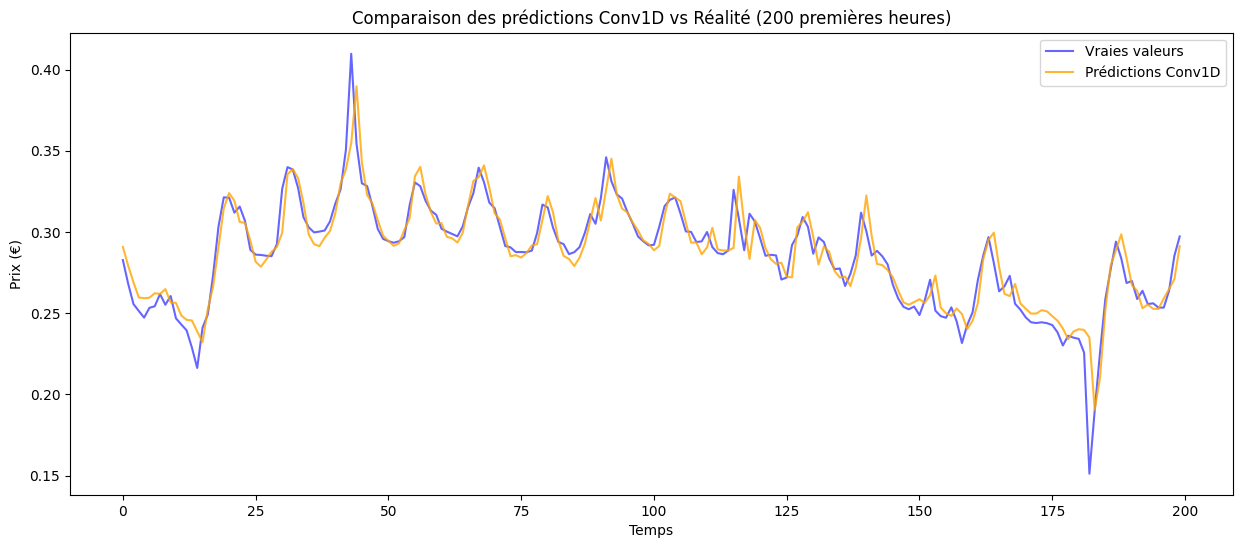

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test_inv[:200], label="Vraies valeurs", color="blue", alpha=0.6)
plt.plot(y_pred_conv1d_inv[:200], label="Prédictions Conv1D", color="orange", alpha=0.8)
plt.title("Comparaison des prédictions Conv1D vs Réalité (200 premières heures)")
plt.xlabel("Temps")
plt.ylabel("Prix (€)")
plt.legend()
plt.show()


# Data augmentation

In [ ]:
import numpy as np

def jittering(data, noise_level=0.01):
    """Ajoute un bruit gaussien à la série temporelle"""
    return data + np.random.normal(0, noise_level, size=data.shape)

def scaling(data, scale_factor=0.1):
    """Multiplie la série temporelle par un facteur aléatoire"""
    factor = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    return data * factor

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
import joblib

augmentation_methods = {
    "Jittering": jittering,
    "Scaling": scaling,
}

models_conv1d = {}  # Stocker les modèles entraînés

for name, method in augmentation_methods.items():
    print(f"Entraînement avec augmentation : {name}")

    # Appliquer l'augmentation sur X_train
    X_train_aug = np.array([method(x) for x in X_train])

    # Construire un modèle Conv1D
    model_conv1d = Sequential([
        Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(window_size, 1)),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        Dropout(0.2),
        Flatten(),
        Dense(50, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model_conv1d.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])

    # Entraînement
    history = model_conv1d.fit(X_train_aug, y_train,
                               validation_data=(X_test, y_test),
                               epochs=20, batch_size=32)

    # Sauvegarde du modèle
    model_conv1d.save(f"model_conv1d_{name}.h5")
    models_conv1d[name] = model_conv1d

print("Tous les modèles Conv1D ont été entraînés et sauvegardés !")

Entraînement avec augmentation : Jittering
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0111 - val_mae: 0.0111
Epoch 2/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 3/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 4/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0136 - mae: 0.0136 - val_loss: 0.0111 - val_mae: 0.0111
Epoch 5/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 6/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 7/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 8/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 9/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0125 

Entraînement avec augmentation : Scaling
Epoch 1/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0358 - mae: 0.0358 - val_loss: 0.0188 - val_mae: 0.0188
Epoch 2/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 3/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 4/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 5/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0147 - val_mae: 0.0147
Epoch 6/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 7/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0234 - val_mae: 0.0234
Epoch 8/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0188 - mae: 0.0188 - val_loss: 0.0208 - val_mae: 0.0208
Epoch 9/20
876/

Tous les modèles Conv1D ont été entraînés et sauvegardés !


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results_conv1d = {}

for name, model in models_conv1d.items():
    print(f"Évaluation du modèle {name}")

    # Prédictions
    y_pred_aug = model.predict(X_test)

    # Inverser la normalisation
    y_pred_aug_inv = scaler.inverse_transform(y_pred_aug.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calcul des métriques
    mae_aug = mean_absolute_error(y_test_inv, y_pred_aug_inv)
    rmse_aug = np.sqrt(mean_squared_error(y_test_inv, y_pred_aug_inv))

    results_conv1d[name] = {"MAE": mae_aug, "RMSE": rmse_aug}
    print(f"{name} - MAE : {mae_aug:.6f} | RMSE : {rmse_aug:.6f}")


Évaluation du modèle Jittering
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Jittering - MAE : 0.009942 | RMSE : 0.015548
Évaluation du modèle Scaling
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Scaling - MAE : 0.018724 | RMSE : 0.024346


In [ ]:
import plotly.express as px
import pandas as pd

# Convertir les résultats en DataFrame
df_results_conv1d = pd.DataFrame(results_conv1d).T

# Tracer un graphique interactif
fig = px.bar(df_results_conv1d, x=df_results_conv1d.index, y=["MAE", "RMSE"],
             title="Comparaison des erreurs (MAE & RMSE) pour chaque augmentation avec Conv1D",
             labels={"index": "Méthodes de Data Augmentation", "value": "Erreur"},
             barmode="group", text_auto=True)

# Afficher le graphique
fig.show()


# Données synthétiques

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# Définir le chemin du dossier contenant les fichiers Parquet des scénarios synthétiques
synthetic_data_path = "/content/drive/My Drive/AirLiquideJL/scenarios synthetiques/prix/"

# Lister les fichiers disponibles
files = [f for f in os.listdir(synthetic_data_path) if f.endswith(".parquet")]

# Charger et concaténer tous les fichiers
df_list = [pd.read_parquet(os.path.join(synthetic_data_path, file)) for file in files]
synthetic_df = pd.concat(df_list, ignore_index=True)

# Vérifier l'aperçu des données
print("Aperçu des données synthétiques :")
print(synthetic_df.head())


Aperçu des données synthétiques :
   price  dayofweek  hourofday
0  31.66          0          0
1  31.06          0          1
2  27.81          0          2
3  27.54          0          3
4  25.04          0          4


In [ ]:
# Prendre seulement une fraction des données pour éviter l'overflow
sample_fraction = 0.1
num_samples = int(len(synthetic_df) * sample_fraction)

synthetic_df = synthetic_df.iloc[:num_samples]

start_date = "2023-01-01 00:00:00"

synthetic_df = synthetic_df.copy()
synthetic_df["datetime"] = pd.date_range(start=start_date, periods=len(synthetic_df), freq="h")
synthetic_df.set_index("datetime", inplace=True)

In [ ]:
synthetic_df["computed_dayofweek"] = synthetic_df.index.dayofweek
synthetic_df["computed_hourofday"] = synthetic_df.index.hour

# Vérifier si la reconstruction est correcte
print(synthetic_df[["dayofweek", "computed_dayofweek", "hourofday", "computed_hourofday"]].head(10))

                     dayofweek  computed_dayofweek  hourofday  \
datetime                                                        
2023-01-01 00:00:00          0                   6          0   
2023-01-01 01:00:00          0                   6          1   
2023-01-01 02:00:00          0                   6          2   
2023-01-01 03:00:00          0                   6          3   
2023-01-01 04:00:00          0                   6          4   
2023-01-01 05:00:00          0                   6          5   
2023-01-01 06:00:00          0                   6          6   
2023-01-01 07:00:00          0                   6          7   
2023-01-01 08:00:00          0                   6          8   
2023-01-01 09:00:00          0                   6          9   

                     computed_hourofday  
datetime                                 
2023-01-01 00:00:00                   0  
2023-01-01 01:00:00                   1  
2023-01-01 02:00:00                   2  
2023-01-0

In [ ]:
scaler = MinMaxScaler()
synthetic_df["price"] = scaler.fit_transform(synthetic_df[["price"]])


In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # Utiliser les 24 dernières heures pour prédire la suivante
X_synthetic, y_synthetic = create_sequences(synthetic_df["price"].values, window_size)

# Reshape pour Conv1D (ajout d'un canal = 1)
X_synthetic = X_synthetic.reshape(X_synthetic.shape[0], X_synthetic.shape[1], 1)

print("Taille des données pour Conv1D :", X_synthetic.shape)


Taille des données pour Conv1D : (538113, 24, 1)


In [ ]:
from sklearn.model_selection import train_test_split

split_index = int(len(X_synthetic) * 0.8)
X_train_syn, X_test_syn = X_synthetic[:split_index], X_synthetic[split_index:]
y_train_syn, y_test_syn = y_synthetic[:split_index], y_synthetic[split_index:]

print(f"Taille Train : {X_train_syn.shape}, Taille Test : {X_test_syn.shape}")


Taille Train : (430490, 24, 1), Taille Test : (107623, 24, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Définition du modèle Conv1D
model_conv1d_syn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(window_size, 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation="relu"),
    Dense(1, activation="sigmoid")  # Activation sigmoid pour forcer les valeurs entre [0,1]
])

# Compilation
model_conv1d_syn.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])

# Early Stopping pour éviter l'overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Affichage du modèle
model_conv1d_syn.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 20, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 50)                  │          64,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,709 (299.64 KB)

 Trainable params: 76,709 (299.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entraînement du modèle
history = model_conv1d_syn.fit(X_train_syn, y_train_syn,
                               validation_data=(X_test_syn, y_test_syn),
                               epochs=20, batch_size=32,
                               callbacks=[early_stopping])

Epoch 1/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0160 - mae: 0.0160 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 2/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 0.0101 - mae: 0.0101 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 3/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0084 - val_mae: 0.0084
Epoch 4/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.0094 - mae: 0.0094 - val_loss: 0.0079 - val_mae: 0.0079
Epoch 5/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 0.0092 - mae: 0.0092 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 6/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 0.0091 - mae: 0.0091 - val_loss: 0.0079 - val_mae: 0.0079
Epoch 7/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.0090 - mae: 0.0090 - val_loss: 0.0079 - val_mae: 0.0079
Epoch 8/20
13453/13453 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0089 - mae: 0.0089 - val_loss: 0.0082 - val_mae: 0.0082
Epoch 9/20
13453

In [ ]:
# Sauvegarder le modèle
model_conv1d_syn.save("model_conv1d_synthetic.keras")
print("Modèle Conv1D (Données Synthétiques) sauvegardé !")


Modèle Conv1D (Données Synthétiques) sauvegardé !


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prédictions sur l’ensemble de test
y_pred_conv1d_syn = model_conv1d_syn.predict(X_test_syn)

# Calcul des métriques
mae_conv1d_syn = mean_absolute_error(y_test_syn, y_pred_conv1d_syn)
rmse_conv1d_syn = np.sqrt(mean_squared_error(y_test_syn, y_pred_conv1d_syn))

print(f"MAE Conv1D (Données Synthétiques) : {mae_conv1d_syn:.6f} | RMSE : {rmse_conv1d_syn:.6f}")

3364/3364 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
MAE Conv1D (Données Synthétiques) : 0.007854 | RMSE : 0.011880


In [ ]:
from tensorflow.keras.models import load_model
import joblib

# Charger les modèles avec les formats spécifiques
models_conv1d = {
    "Sans Augmentation (H5)": load_model("model_conv1d.h5"),
    "Avec Jittering (H5)": load_model("model_conv1d_Jittering.h5"),
    "Avec Scaling (H5)": load_model("model_conv1d_Scaling.h5"),
    "Données Synthétiques (Keras)": load_model("model_conv1d_synthetic.keras")
}


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Refaire le fit correctement sur y_train + y_test
scaler = MinMaxScaler()
scaler.fit(np.concatenate((y_train.reshape(-1, 1), y_test.reshape(-1, 1)), axis=0))

# Appliquer la normalisation
y_train = scaler.transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Vérifier la plage après correction
print("Min et Max de y_train après correction :", y_train.min(), y_train.max())
print("Min et Max de y_test après correction :", y_test.min(), y_test.max())


Min et Max de y_train après correction : 0.13104208237781814 1.0
Min et Max de y_test après correction : 0.0 0.8215742919260209


In [ ]:
# Associer chaque modèle à son bon dataset de test
test_datasets = {
    "Sans Augmentation (H5)": (X_test, y_test),
    "Avec Jittering (H5)": (X_test, y_test),  # Même dataset que sans augmentation
    "Avec Scaling (H5)": (X_test, y_test),  # Même dataset que sans augmentation
    "Données Synthétiques (Keras)": (X_test_syn, y_test_syn)  # Dataset des données synthétiques
}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results_conv1d = {}

for name, model in models_conv1d.items():
    print(f"-> Prédiction avec : {name}")

    # Sélectionner le bon X_test et y_test en fonction du modèle
    X_test_current, y_test_current = test_datasets[name]

    # Faire des prédictions
    y_pred = model.predict(X_test_current)

    # Vérifier et corriger si besoin avant inverse_transform()
    y_pred = np.clip(y_pred, 0, 1)

    # Inverser la normalisation
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test_current.reshape(-1, 1))

    # Calculer les métriques
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    # Stocker les résultats
    results_conv1d[name] = {"MAE": mae, "RMSE": rmse}
    print(f"{name} - MAE : {mae:.6f} | RMSE : {rmse:.6f}")


-> Prédiction avec : Sans Augmentation (H5)
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Sans Augmentation (H5) - MAE : 0.007395 | RMSE : 0.012618
-> Prédiction avec : Avec Jittering (H5)
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Avec Jittering (H5) - MAE : 0.009942 | RMSE : 0.015548
-> Prédiction avec : Avec Scaling (H5)
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Avec Scaling (H5) - MAE : 0.018724 | RMSE : 0.024346
-> Prédiction avec : Données Synthétiques (Keras)
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Données Synthétiques (Keras) - MAE : 0.007854 | RMSE : 0.011880


In [ ]:
import plotly.express as px
import pandas as pd

# Convertir les résultats en DataFrame
df_results_conv1d = pd.DataFrame(results_conv1d).T  # Transposer pour que les modèles soient en ligne

# Tracer un graphique interactif
fig = px.bar(df_results_conv1d, x=df_results_conv1d.index, y=["MAE", "RMSE"],
             title="Comparaison des erreurs (MAE & RMSE) pour chaque modèle Conv1D",
             labels={"index": "Méthodes de Data Augmentation", "value": "Erreur"},
             barmode="group", text_auto=True)  # Afficher les valeurs sur les barres

# Afficher le graphique
fig.show()


In [ ]:
import numpy as np

def generate_noisy_scenarios(data, num_variations=5, noise_levels=[0.01, 0.02, 0.03]):
    """Génère plusieurs versions bruitées des données originales."""
    noisy_data = [data.copy()]  # Inclure le scénario original

    for _ in range(num_variations):
        for noise in noise_levels:
            noisy_version = data.copy()
            noisy_version["price"] += np.random.normal(0, noise, size=noisy_version["price"].shape)
            noisy_version["price"] = np.clip(noisy_version["price"], data["price"].min(), data["price"].max())  # Éviter des valeurs aberrantes
            noisy_data.append(noisy_version)

    return pd.concat(noisy_data, ignore_index=True)

# Appliquer sur les scénarios synthétiques
synthetic_df_augmented = generate_noisy_scenarios(synthetic_df)

print("Nombre total d'exemples après augmentation :", len(synthetic_df_augmented))


Nombre total d'exemples après augmentation : 8610192


In [ ]:
# Normaliser les nouveaux scénarios synthétiques augmentés
scaler = MinMaxScaler()
synthetic_df_augmented["price"] = scaler.fit_transform(synthetic_df_augmented[["price"]])

# Créer des séquences temporelles (`window_size=24`)
X_synthetic_aug, y_synthetic_aug = create_sequences(synthetic_df_augmented["price"].values, window_size)

# Reshape pour Conv1D
X_synthetic_aug = X_synthetic_aug.reshape(X_synthetic_aug.shape[0], X_synthetic_aug.shape[1], 1)

# Diviser en `train/test`
split_index = int(len(X_synthetic_aug) * 0.8)
X_train_syn, X_test_syn = X_synthetic_aug[:split_index], X_synthetic_aug[split_index:]
y_train_syn, y_test_syn = y_synthetic_aug[:split_index], y_synthetic_aug[split_index:]

print(f"Taille du jeu d'entraînement après augmentation : {X_train_syn.shape}")


Taille du jeu d'entraînement après augmentation : (6888134, 24, 1)


In [ ]:
import pandas as pd

def reduce_dataset(data, fraction=0.1, method="time"):
    if method == "random":
        return data.sample(frac=fraction, random_state=42).reset_index(drop=True)

    elif method == "time":
        step = int(1 / fraction)
        return data.iloc[::step].reset_index(drop=True)

    else:
        raise ValueError("Méthode inconnue. Utiliser 'random' ou 'time'.")

# Appliquer la réduction à 5% sur les scénarios synthétiques augmentés
synthetic_df_reduced_5 = reduce_dataset(synthetic_df_augmented, fraction=0.05, method="time")

print("Taille des données après réduction à 5% :", synthetic_df_reduced_5.shape)


Taille des données après réduction à 5% : (430510, 5)


In [ ]:
# Normaliser les données réduites
scaler = MinMaxScaler()
synthetic_df_reduced_5["price"] = scaler.fit_transform(synthetic_df_reduced_5[["price"]])

# Créer des séquences temporelles (`window_size=24`)
X_synthetic_reduced_5, y_synthetic_reduced_5 = create_sequences(synthetic_df_reduced_5["price"].values, window_size)

# Reshape pour Conv1D
X_synthetic_reduced_5 = X_synthetic_reduced_5.reshape(X_synthetic_reduced_5.shape[0], X_synthetic_reduced_5.shape[1], 1)

# Diviser en `train/test`
split_index = int(len(X_synthetic_reduced_5) * 0.8)
X_train_syn_5, X_test_syn_5 = X_synthetic_reduced_5[:split_index], X_synthetic_reduced_5[split_index:]
y_train_syn_5, y_test_syn_5 = y_synthetic_reduced_5[:split_index], y_synthetic_reduced_5[split_index:]

print(f"Taille du jeu d'entraînement après réduction à 5% : {X_train_syn_5.shape}")


Taille du jeu d'entraînement après réduction à 5% : (344388, 24, 1)


In [ ]:
# Définition du modèle `Conv1D`
model_conv1d_syn_5 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(window_size, 1)),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation="relu"),
    Dense(1, activation="sigmoid")  # Activation sigmoid pour forcer les valeurs entre [0,1]
])

# Compilation
model_conv1d_syn_5.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mae"])

# Entraînement avec le dataset réduit à 10%
history = model_conv1d_syn_5.fit(X_train_syn_5, y_train_syn_5,
                                  validation_data=(X_test_syn_5, y_test_syn_5),
                                  epochs=20, batch_size=32)

# Sauvegarde du modèle réduit
model_conv1d_syn_5.save("model_conv1d_synthetic_reduced_10.keras")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 2/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 3/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 4/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 5/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 6/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 7/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 8/20
10763/10763 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 9/20
10763

In [ ]:
from tensorflow.keras.models import load_model
import joblib

# Charger les modèles entraînés sur différentes tailles de dataset
models_conv1d = {
    "Sans Augmentation (100%)": load_model("model_conv1d.h5"),
    "Données Synthétiques (100%)": load_model("model_conv1d_synthetic.keras"),
    "Dataset Réduit (5%)": load_model("model_conv1d_synthetic_reduced_10.keras")
}


In [ ]:
from tensorflow.keras.models import load_model
import joblib

# Charger les modèles entraînés sur différentes tailles de dataset
models_conv1d = {
    "Sans Augmentation (100%)": load_model("model_conv1d.h5"),
    "Données Synthétiques (100%)": load_model("model_conv1d_synthetic.keras"),
    "Dataset Réduit (5%)": load_model("model_conv1d_synthetic_reduced_10.keras")
}

# Associer chaque modèle avec son `X_test` et `y_test`
test_datasets = {
    "Sans Augmentation (100%)": (X_test, y_test),
    "Données Synthétiques (100%)": (X_test_syn, y_test_syn),
    "Dataset Réduit (5%)": (X_test_syn_5, y_test_syn_5)
}


print("Tous les modèles Conv1D ont été chargés avec succès !")


Tous les modèles Conv1D ont été chargés avec succès !


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results_conv1d = {}

for name, model in models_conv1d.items():
    print(f"--> Prédiction avec : {name}")

    # Sélectionner le bon `X_test` et `y_test` en fonction du modèle
    X_test_current, y_test_current = test_datasets[name]

    # Faire des prédictions
    y_pred = model.predict(X_test_current)

    # Vérifier et corriger si besoin avant inverse_transform()
    y_pred = np.clip(y_pred, 0, 1)

    # Inverser la normalisation
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test_current.reshape(-1, 1))

    # Calculer les métriques
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    # Stocker les résultats
    results_conv1d[name] = {"MAE": mae, "RMSE": rmse}
    print(f"{name} - MAE : {mae:.6f} | RMSE : {rmse:.6f}")


--> Prédiction avec : Sans Augmentation (100%)
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sans Augmentation (100%) - MAE : 0.007395 | RMSE : 0.012618
--> Prédiction avec : Données Synthétiques (100%)
3364/3364 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Données Synthétiques (100%) - MAE : 0.007854 | RMSE : 0.011880
--> Prédiction avec : Dataset Réduit (5%)
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Dataset Réduit (5%) - MAE : 0.032514 | RMSE : 0.043174
